# Shopee-Product-Matching
![Shopee](https://cdn.lynda.com/course/563030/563030-636270778700233910-16x9.jpg)


1. If you want to learn more about this amazing competition hosted by [Shopee](https://www.kaggle.com/c/shopee-product-matching), Please visit following [Shopee EDA Image AutoEncoder](https://www.kaggle.com/code/chiragtagadiya/shopee-basic-autoencoder).
2. This Notebook contains EDA and Image AutoEncoder solution.

In [2]:
%config Completer.use_jedi = False

# Import Packages

In [3]:
import sys
sys.path.append('../input/timmmaster')
import timm

In [4]:
import math
import os
import numpy as np
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import timm
import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F 
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import date
from sklearn.metrics import f1_score, accuracy_score
from collections  import Counter
import math
import random

In [5]:
def seed_torch(seed=42):
    random.seed(seed+1)
#     torch.backends.cudnn.deterministic=True
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.RandomState(seed)
    
seed_torch()

In [6]:
# class ArcFaceClassifier(nn.Module):
#     def __init__(self, emb_size, output_classes):
#         super().__init__()
#         self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
#         nn.init.kaiming_uniform_(self.W)
#     def forward(self, x):
#         # Step 1:
#         x_norm = F.normalize(x)
#         W_norm = F.normalize(self.W, dim=0)
#         # Step 2:
#         return x_norm @ W_norm
    
# def arcface_loss(cosine, targ, m=.4):
#     # this prevents nan when a value slightly crosses 1.0 due to numerical error
#     cosine = cosine.clip(-1+1e-7, 1-1e-7) 
#     # Step 3:
#     arcosine = cosine.arccos()
#     # Step 4:
#     print(arcosine)
#     print(" ***",F.one_hot(targ, num_classes = output_classes))
#     arcosine += F.one_hot(targ, num_classes = output_classes) * m
#     # Step 5:
#     cosine2 = arcosine.cos()
#     # Step 6:
#     return F.cross_entropy(cosine2, targ)

# Configuration Options


In [7]:
TRAIN_DIR = '../input/shopee-product-matching/train_images'
TEST_DIR = '../input/shopee-product-matching/test_images'
TRAIN_CSV = '../input/crossvalidationfolds/folds.csv'
MODEL_PATH = './'


class CFG:
    seed = 123 
    img_size = 512
    classes = 11014
    fc_dim = 512
    epochs = 1
    batch_size = 16
    num_workers = 3
    model_name = 'tf_efficientnet_b0'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    scheduler_params = {
        "lr_start": 3e-4,#1e-5
        "lr_max": 1e-5 * batch_size,     # 1e-5 * 32 (if batch_size(=32) is different then)
        "lr_min": 1e-6,
        "lr_ramp_ep": 5,
        "lr_sus_ep": 0,
        "lr_decay": 0.8,
    }
    model_path='../input/21-mar-lr-large/2022-03-20_softmax_512x512_tf_efficientnet_b4.pt'
    isTraining=True
    

# Solution Approach

* In this competition it is given that,if two or more images have **same label group** then they are **similar products.** 
* Basically we can use this information to transfer the business problem into **multi class classification** problem.
* From Image EDA, I found out that we have **11014** different classes, and dataset is **not balanced dataset**
* If you see below plot, we can clearly see that there are **hardly 1000 data points having more than 10 products per label.*
* In this notebook I used **Weighted Sampler technique used in pytorch for handling imbalanced classification problem**


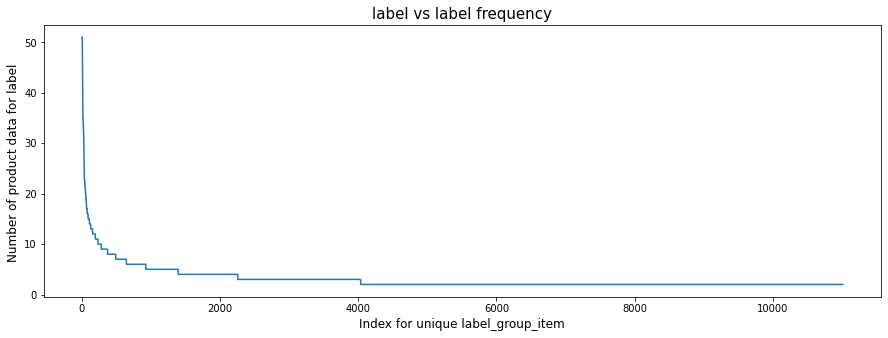

In [8]:
train_df=pd.read_csv('../input/shopee-product-matching/train.csv')
labelGroups = train_df.label_group.value_counts()
# print(labelGroups)
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(labelGroups)), labelGroups.values)
plt.xlabel("Index for unique label_group_item", size=12)
plt.ylabel("Number of product data for label ", size=12)
plt.title("label vs label frequency", size=15)
plt.show()

# Create Custom DataSet

In [9]:
class ShopeeDataset(Dataset):
    
    def __init__(self, df,root_dir, isTraining=False, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):       
        row = self.df.iloc[idx]
        label = row.label_group
        image_path = os.path.join(self.root_dir, row.image)
        
        # read image convert to RGB and apply augmentation
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            aug = self.transform(image=image)
            image = aug['image']
        
        return image, torch.tensor(label).long()
            




# Create Data Augmentation For training and validation Data

In [10]:

def getAugmentation(IMG_SIZE, isTraining=False):
    
    if isTraining:
        return albumentations.Compose([
            albumentations.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=120, p=0.75),
            albumentations.RandomBrightness(limit=(0.09, 0.6), p=0.5),
            albumentations.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]
            ),
            ToTensorV2(p=1.0)
        ])
    else:
        return albumentations.Compose([
            albumentations.Resize(IMG_SIZE, IMG_SIZE, always_apply=True),
            albumentations.Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]
            ),
            ToTensorV2(p=1.0)
        ])

# Build Model

In [11]:
class ArcFaceModule(nn.Module):
    def __init__(self, in_features, out_features, scale, margin, easy_margin=False, ls_eps=0.0 ):
        super(ArcFaceModule, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.easy_margin=easy_margin
        self.ls_eps=ls_eps
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
        
        
        
    
    def forward(self, input, label):
        
        # cosine = X.W = ||X|| .||W|| . cos(theta) 
        # if X and W are normalize then dot product X, W = will be cos theta
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        # phi = cos(theta + margin) = cos theta . cos(margin) -  sine theta .  sin(margin)
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            
        one_hot = torch.zeros(cosine.size(), device=CFG.device)
        # one hot encoded
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        #  output = label == True ? phi : cosine  
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        # scale the output
        output *= self.scale
        # return cross entropy loss on scalled output
        return output, nn.CrossEntropyLoss()(output,label)

In [12]:
   
class ShopeeEncoderBackBone(nn.Module):
    
    def __init__(self,
                     model_name='tf_efficientnet_b3',
                     loss_fn='ArcFace',
                     classes = CFG.classes,
                     fc_dim = CFG.fc_dim,
                     pretrained=True,
                     use_fc=True,
                     isTraining=True
                ):
        
        
        super(ShopeeEncoderBackBone,self).__init__()
        
        # create bottlenack backbone network from pretrained model 
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.use_fc = use_fc
        self.loss_fn =loss_fn
        self.isTraining =isTraining
        
        # build top fc layers (Embedding that we are looking at testing time to represent the entire image)
        if self.use_fc:
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(in_features,fc_dim )
            self.bn = nn.BatchNorm1d(fc_dim)
            self.init_params()
            in_features = fc_dim
        self.loss_fn = loss_fn
        if self.loss_fn=='softmax':
            self.final = nn.Linear(in_features, CFG.classes)
        elif self.loss_fn =='ArcFace':
            self.final = ArcFaceModule( in_features,
                                        CFG.classes,
                                        scale = 30,
                                        margin = 0.5,
                                        easy_margin = False,
                                        ls_eps = 0.0)
            
    def forward(self, image, label):
        features = self.get_features(image)
        if self.isTraining:
            logits = self.final(features, label)
            return logits
        else:
            return features
    
    def init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias,0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
        
        
    def get_features(self,inp):
        batch_dim = inp.shape[0]
        inp = self.backbone(inp)
        inp = self.pooling(inp).view(batch_dim, -1)
        if self.use_fc and self.isTraining:
            inp = self.dropout(inp)
            inp = self.fc(inp)
            inp = self.bn(inp)
            
        return inp
    
    
# shoppe_label_classfier = ShopeeLabelGroupClassfier()


# Custom Learning Rate Scheduler

In [13]:
import torch 
from torch.optim.lr_scheduler import _LRScheduler


class ShopeeScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.4,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ShopeeScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

# Training  Single Epoch


In [14]:
def training_one_epoch(epoch_num,model, dataloader,optimizer, scheduler, device, loss_criteria):
    avgloss = 0.0
    # put model in traning model
    model.train()
    tq = tqdm(enumerate(dataloader), total=len(dataloader))
    y_true=[]
    y_pred=[]
    for idx, data in tq:
        batch_size = data[0].shape[0]
        images = data[0]
        targets = data[1]
        # zero out gradient
        optimizer.zero_grad()
        # put input and target to device
        images = images.to(device)
        targets = targets.to(device)
        # pass input to the model
        output,loss = model(images,targets)
        # backpropogation 
        loss.backward()
        # update learning rate step
        optimizer.step() 
        predicted_label=torch.argmax(output,1)
        y_true.extend(targets.detach().cpu().numpy())
        y_pred.extend(predicted_label.detach().cpu().numpy())
        # avg loss
        avgloss += loss.item() 

        tq.set_postfix({'loss' : '%.6f' %float(avgloss/(idx+1)), 'LR' : optimizer.param_groups[0]['lr']})
        
    # lr scheduler step after each epoch
    scheduler.step()
    f1_score_metric = f1_score(y_true, y_pred, average='micro')
    tq.set_postfix({'Training f1 score' : '%.6f' %float(f1_score_metric)})
    return avgloss / len(dataloader),f1_score_metric
    
    
    
    
    
    

# Validating Single Epoch

In [15]:


def validation_one_epoch(model, dataloader, epoch, device, loss_criteria):
    avgloss = 0.0
    # put model in traning model
    model.eval()
    tq = tqdm(enumerate(dataloader), desc = "Training Epoch { }" + str(epoch+1))
    
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, data in tq:
            batch_size = data[0].shape[0]
            images = data[0]
            targets = data[1]

            images = images.to(device)
            targets = targets.to(device)
            output,loss = model(images,targets)
            predicted_label=torch.argmax(output,1)
            y_true.extend(targets.detach().cpu().numpy())
            y_pred.extend(predicted_label.detach().cpu().numpy())

            avgloss += loss.item() 

            tq.set_postfix({'validation loss' : '%.6f' %float(avgloss/(idx+1))})
    f1_score_metric = f1_score(y_true, y_pred, average='micro')
    tq.set_postfix({'validation f1 score' : '%.6f' %float(f1_score_metric)})
    return avgloss / len(dataloader),f1_score_metric
        


## Helper Function for Handling class imbalanced data

In [16]:
import numpy as np 
def get_class_weights(data):
    # Word dictionary keys will be label and value will be frequency of label in dataset
    weight_dict=Counter(data['label_group'])
    # for each data point get label count data
    class_sample_count= np.array([weight_dict[row[4]] for row in data.values])
    # each data point weight will be inverse of frequency
    weight = 1. / class_sample_count
    weight=torch.from_numpy(weight)
    return weight

# Training Loop

In [17]:
class ArcFace(nn.Module):
    r"""Implement of ArcFace (https://arxiv.org/pdf/1801.07698v1.pdf):
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            device_id: the ID of GPU where the model will be trained by model parallel. 
                       if device_id=None, it will be trained on CPU without model parallel.
            s: norm of input feature
            m: margin
            cos(theta+m)
        """
    def __init__(self, in_features, out_features, s = 64.0, m = 0.50, easy_margin = False):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.s = s
        self.m = m
        
        self.kernel = Parameter(torch.FloatTensor(in_features, out_features))
        #nn.init.xavier_uniform_(self.kernel)
        nn.init.normal_(self.kernel, std=0.01)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis = 1)
        kernel_norm = l2_norm(self.kernel, axis = 0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        with torch.no_grad():
            origin_cos = cos_theta.clone()
        target_logit = cos_theta[torch.arange(0, embbedings.size(0)), label].view(-1, 1)

        sin_theta = torch.sqrt(1.0 - torch.pow(target_logit, 2))
        cos_theta_m = target_logit * self.cos_m - sin_theta * self.sin_m #cos(target+margin)
        if self.easy_margin:
            final_target_logit = torch.where(target_logit > 0, cos_theta_m, target_loit)
        else:
            final_target_logit = torch.where(target_logit > self.th, cos_theta_m, target_logit - self.mm)

        cos_theta.scatter_(1, label.view(-1, 1).long(), final_target_logit)
        output = cos_theta * self.s
        return output, origin_cos * self.s


# TESTING

In [18]:
CFG.epochs =25

In [24]:
def run_training(model=None, history=None):
    data = pd.read_csv('../input/cvfolds/folds.csv')
    # label encoding
    labelencoder= LabelEncoder()
    data['label_group_original']=data['label_group']
    data['label_group'] = labelencoder.fit_transform(data['label_group'])
    
    
    
    # create training_data and validation data initially not using k fold
    train_data = data[data['fold']!=0]
    validation_data = data[data['fold']==0]
    #     train_data = data
    # training augmentation
    train_aug = getAugmentation(CFG.img_size,isTraining=True )
    validation_aug = getAugmentation(CFG.img_size, isTraining=False)
    # create custom train and validation dataset
    
    trainset = ShopeeDataset(train_data, TRAIN_DIR, isTraining=True, transform = train_aug)
    validset = ShopeeDataset(validation_data, TRAIN_DIR, isTraining=False, transform = validation_aug)
    #print(len(data))
    #print(len(trainset))
    # create data sampler
                  
    # get weights for  classes
    samples_weight=get_class_weights(train_data)
    
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, num_samples=len(samples_weight))   
    
    
    # create custom training and validation data loader num_workers=CFG.num_workers,
    train_dataloader = DataLoader(trainset, batch_size=CFG.batch_size,
                          drop_last=True,pin_memory=True,sampler=sampler)
    
    validation_dataloader = DataLoader(validset, batch_size=CFG.batch_size,
                        drop_last=True,pin_memory=True)
    
    
    # define loss function
    loss_criteria = nn.CrossEntropyLoss()
    loss_criteria.to(CFG.device)
    # define model
    
    if not model:
        model = ShopeeEncoderBackBone()
        model.to(CFG.device)
    
    # define optimzer
    optimizer = torch.optim.Adam(model.parameters(),lr= CFG.scheduler_params['lr_start'])
    
    # learning rate scheudler
    #scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=1, eta_min=1e-6, last_epoch=-1)
    scheduler = ShopeeScheduler(optimizer, **CFG.scheduler_params)
    if not history:
        history = {'train_loss':[],'validation_loss':[],'train_f1_score':[],'scheduler':[], 'valid_f1_score':[]}
    for epoch in range(CFG.epochs):
        
        # get current epoch training loss
        avg_train_loss, avg_f1_score = training_one_epoch(epoch_num = epoch,
                                           model = model,
                                           dataloader = train_dataloader,
                                           optimizer = optimizer,
                                           scheduler = scheduler,
                                           device = CFG.device, 
                                           loss_criteria = loss_criteria)
        print("Epoch : {} avg f1 {}".format(epoch+1,avg_f1_score))
        # get current epoch validation loss
        avg_validation_loss, avg_valid_f1_score  = validation_one_epoch(model = model,
                                          dataloader = validation_dataloader,
                                          epoch = epoch,
                                          device = CFG.device,
                                          loss_criteria = loss_criteria)
        
        print("Epoch : {} avg Validation f1 {}".format(epoch+1,avg_f1_score))
        
        history['train_loss'].append(avg_train_loss)
        history['validation_loss'].append(avg_validation_loss)
        history['train_f1_score'].append(avg_f1_score) 
        history['valid_f1_score'].append(avg_valid_f1_score)
        history['scheduler'].append(scheduler.state_dict())
        # save model
        torch.save(model.state_dict(), MODEL_PATH +"Train_F1_score_"+str(avg_f1_score)+"valid_f1_score"+str(avg_valid_f1_score)+"_"+"Epoch_"+str(epoch)+"_lr_start_"+str(CFG.scheduler_params['lr_start'])+"_lr_max_"+str(CFG.scheduler_params['lr_max'])+'_softmax_512x512_{}.pt'.format(CFG.model_name))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
            },
         MODEL_PATH +"F1_score_"+str(avg_f1_score)+"valid_f1_score"+str(avg_valid_f1_score)+"_"+"Epoch_"+str(epoch)+"_lr_start_"+str(CFG.scheduler_params['lr_start'])+"_lr_max_"+str(CFG.scheduler_params['lr_max'])+'_softmax_512x512_{}.pt'.format(CFG.model_name)
        )
    
        
        
    return model, history

In [25]:
history={'train_loss':[],'validation_loss':[],'train_f1_score':[], 'scheduler':[], 'valid_f1_score':[]}
# retraining with saved model so model and history will not be None
# model = ShopeeEncoderBackBone()
# model.to(CFG.device)
# model.load_state_dict(torch.load('../input/arc-face-trained-b3-059/F1_score_0.5976635514018691_Epoch_21_lr_start_0.0003_lr_max_0.00016_softmax_512x512_tf_efficientnet_b0.pt'))
CFG.isTraining=True
CFG.epochs=1
if CFG.isTraining:
    model, history = run_training(model=None, history=None)
    

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
100%|██████████| 1712/1712 [25:16<00:00,  1.13it/s, loss=21.505441, LR=0.0003]


Epoch : 1 avg f1 0.00018253504672897196


Training Epoch { }1: 428it [03:38,  1.96it/s, validation loss=19.710756]


Epoch : 1 avg Validation f1 0.00018253504672897196


In [ ]:
history 

In [ ]:
# daddy cool DADDY COOL23 123
# 456789101121 Daddy Cool123456789

In [ ]:
# import torch
# torch.cuda.empty_cache()
# import gc


# gc.collect()

# Plot Training and Validation Loss and Accuracy

In [ ]:
# Daddy cool  

In [ ]:
if CFG.isTraining:
    epoch_lst = [ i+1 for i in range(15)]
    plt.plot(epoch_lst,history['train_loss'])

    plt.xlabel("Epoch number")
    plt.ylabel('Training Loss')
    plt.title('Training Loss ArcFace Loss Function')
    plt.show()

In [ ]:
if CFG.isTraining:
    plt.plot(epoch_lst,history['train_f1_score'])
    plt.xlabel("Epoch number")
    plt.ylabel('train_f1_score ')
    plt.title('Train_f1_score Loss ArcFace Loss Function')
    plt.show()

# Prediction 

In [ ]:
def prediction(model):
    data = pd.read_csv('../input/cvfolds/folds.csv')

    # label encoding
    labelencoder= LabelEncoder()
    data['label_group'] = labelencoder.fit_transform(data['label_group'])
    # Prepare Validation data
    validation_data = data[data['fold']==0]
    validation_aug = getAugmentation(CFG.img_size,isTraining=False)
    validset = ShopeeDataset(validation_data, TRAIN_DIR, isTraining=False, transform = validation_aug)
    test_data_loader = torch.utils.data.DataLoader(validset,batch_size=CFG.batch_size)
    
    # put model in evalution mode
    
    model.eval()
    
    tq = tqdm(enumerate(test_data_loader))
    y_true=[]
    y_pred=[]
    with torch.no_grad():
        for idx, data in tq:
            images = data[0]
            targets = data[1]
            
            images = images.to(CFG.device)
            targets = targets.to(CFG.device)
            y_true.extend(targets.detach().cpu().numpy())
            output,loss = model(images,targets)
            outputs=torch.argmax(output,1)
            y_pred.extend(outputs.detach().cpu().numpy())
        
    f1_score_metric = f1_score(y_true, y_pred, average='micro')
    return f1_score_metric
    

In [ ]:
f1 = prediction(model)
print(f1)

In [ ]:
# if not CFG.isTraining:
model = ShopeeEncoderBackBone().to(CFG.device)
model.load_state_dict(torch.load('../input/arc-face-trained-b3-059/F1_score_0.5976635514018691_Epoch_21_lr_start_0.0003_lr_max_0.00016_softmax_512x512_tf_efficientnet_b0.pt'))
#     f1=prediction(model)
#     print("F1 score {}".format(f1))

In [ ]:
model1 = torch.load('.../input/arc-face-trained-b3-059/F1_score_0.5976635514018691_Epoch_21_lr_start_0.0003_lr_max_0.00016_softmax_512x512_tf_efficientnet_b0.pt')

In [ ]:
model.load_state_dict(model1['model_state_dict'])

In [ ]:
model1.keys()

In [ ]:
model1['epoch']